<a href="https://colab.research.google.com/github/lukelwelsh/monkeypox_graph/blob/main/monkeypox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip3 install --upgrade pip
! pip3 install geopandas shapely descartes geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 60.7 MB/s eta 0:00:00


In [138]:
import geopandas
import io
import zipfile
import csv
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML


In [5]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
# credit to https://towardsdatascience.com/7-ways-to-load-external-data-into-google-colab-7ba73e7d5fc7

In [7]:
!kaggle datasets download -d andrewmvd/global-monkeypox-cases

  0% 0.00/354k [00:00<?, ?B/s]
100% 354k/354k [00:00<00:00, 84.1MB/s]


In [8]:
zf = zipfile.ZipFile("global-monkeypox-cases.zip")
file = zf.namelist()[0]
file

'monkeypox_df.csv'

In [9]:
df = pd.read_csv(zf.open(file))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3,8,10,11,12,14,16,18,19,20,21,22,23,24,25,29,34) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
conf_dates = df[~df['Date_confirmation'].isna()]
conf_dates = conf_dates[conf_dates['Status'] == 'confirmed']
simp_table = conf_dates[['Country', 'Date_confirmation']]

In [232]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[world.name!="Antarctica"]
world = world[['name', 'geometry', 'pop_est']]

In [231]:
# names = set(world['name'])
# wack_countries = []
# for country in simp_table['Country']:
#   if not country in names:
#     wack_countries.append(country)
# set(wack_countries)

In [37]:
monk_to_map = {'Andorra': 'Spain', 
               'Aruba': 'Venezuela', 
               'Barbados': 'Trinidad and Tobago', 
               'Bermuda': 'United States of America', 
               'Bosnia And Herzegovina': 'Bosnia and Herz.',
               'Central African Republic': 'Central African Rep.',
               'Curaçao': 'Venezuela',
               'Czech Republic': 'Czechia',
               'Democratic Republic Of The Congo': 'Dem. Rep. Congo',
               'Dominican Republic': 'Dominican Rep.',
               'England': 'United Kingdom',
               'Gibraltar': 'Spain',
               'Guadeloupe': 'Venezuela',
               'Malta': 'Italy',
               'Martinique': 'Venezuela',
               'Monaco': 'France',
               'Northern Ireland': 'United Kingdom',
               'Republic of Congo': 'Congo',
               'Saint Martin (French part)': 'Puerto Rico',
               'Scotland': 'United Kingdom',
               'Singapore': 'Malaysia',
               'United States': 'United States of America',
               'Wales': 'United Kingdom'}

In [123]:
simp_table = simp_table.replace(monk_to_map)
fix_date = {'2022-1-31': '2022-01-31'}
simp_table = simp_table.replace(fix_date)

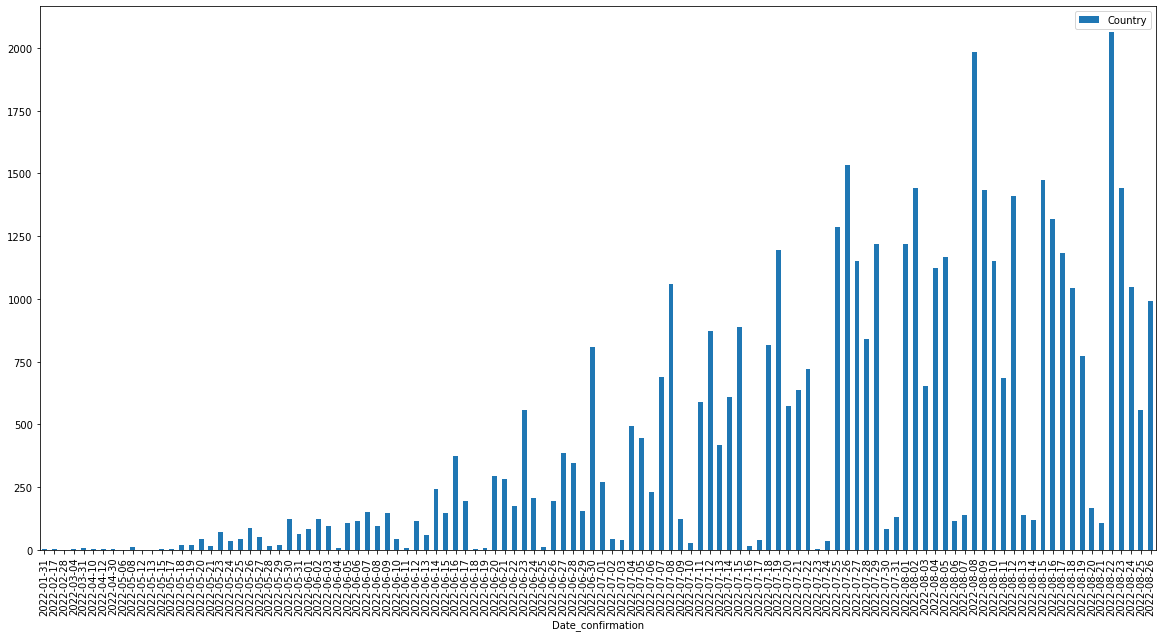

In [57]:
simp_table.groupby('Date_confirmation').count().plot(kind='bar', figsize=(20, 10))

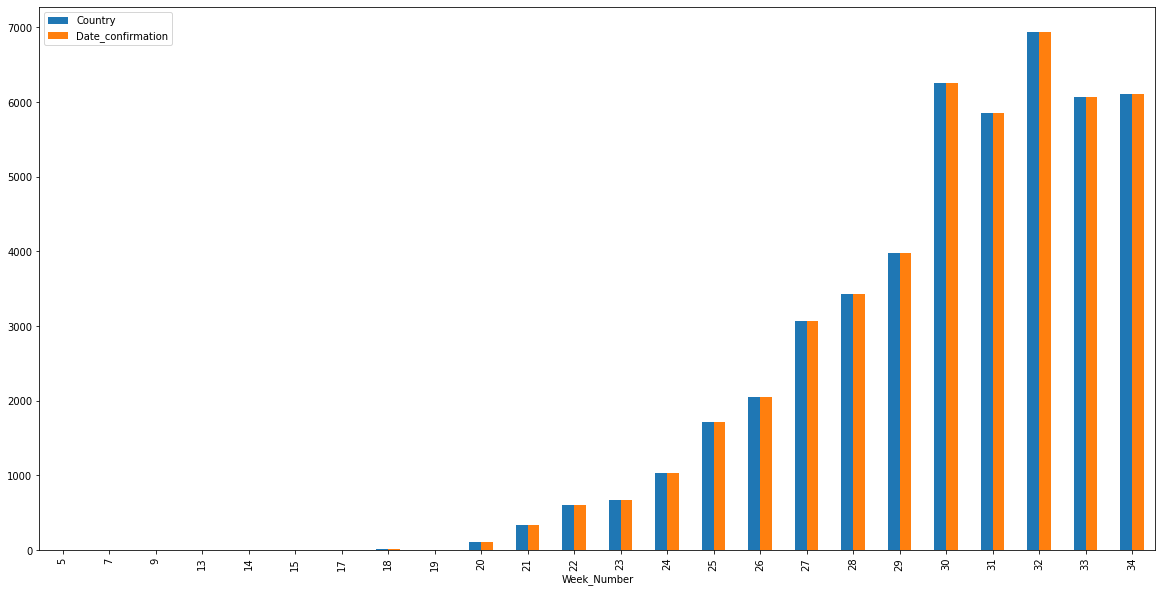

In [126]:
simp_table['Date_confirmation'] = pd.to_datetime(df['Date_confirmation'])
simp_table['Week_Number'] = simp_table['Date_confirmation'].dt.isocalendar().week
simp_table.groupby('Week_Number').count().plot(kind='bar', figsize=(20, 10))

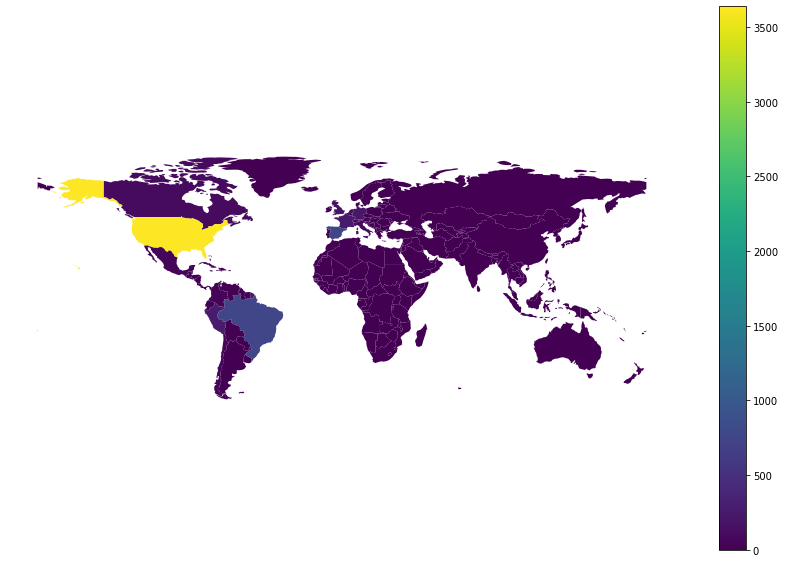

In [259]:
week_data = simp_table[simp_table['Week_Number'] == 32]
week_summ = week_data['Country'].value_counts().to_frame().reset_index()
week_summ.columns = ['name', 'case_count']
df_combined = pd.merge(world, week_summ, how = 'left')
df_combined['case_count'] = df_combined['case_count'].fillna(0)
fig, ax = plt.subplots(figsize=(15, 10))
df_combined.plot(column = 'case_count', ax = ax, legend = True)
ax.set_axis_off()

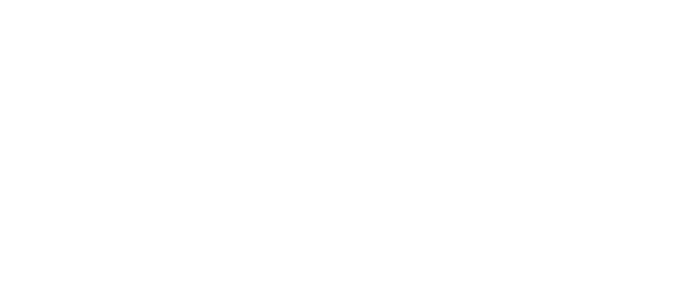

In [298]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.set_axis_off()
def map_week(frame_num):
  week_data = simp_table[simp_table['Week_Number'] == frame_num+1]
  week_summ = week_data['Country'].value_counts().to_frame().reset_index()
  week_summ.columns = ['name', 'case_count']
  df_combined = pd.merge(world, week_summ, how = 'left')
  if frame_num == 1:
    artist = df_combined.plot(column = 'case_count', missing_kwds={'color': 'lightgrey'}, cmap = 'OrRd', linewidth=0.8, edgecolor='0.8', ax = ax, vmin = 1, vmax = 4000, legend = True)
  else:
    artist = df_combined.plot(column = 'case_count', cmap = 'OrRd', linewidth=0.8, edgecolor='0.8', ax = ax, vmin = 1, vmax = 4000)
  ax.set_title('week of 2022 = '+ str(frame_num+1))
  return artist

In [299]:
anim = FuncAnimation(fig, map_week, frames = 34, interval = 500)
html = anim.to_html5_video()
HTML(html)

<Figure size 432x288 with 0 Axes>